# Solução analítica

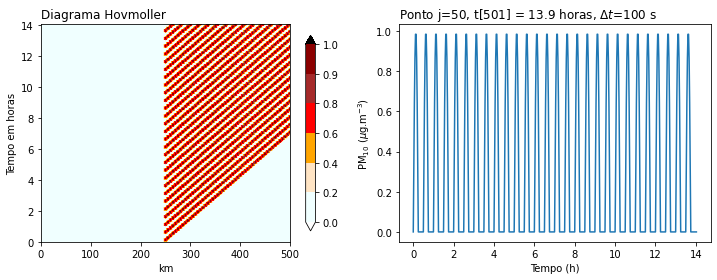

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from matplotlib import animation, rc
from functions import *
import scipy.sparse as sp

# Condições do exercício
# ----------------------
Nx, dx, Nt, dt, U  = 101, 5000, 506, 100, 10, 
hora = round((Nt-1)*dt/3600,1)
x, _ = np.linspace(0, (Nx-1)*5000, Nx, retstep = True)
t, _ = np.linspace(0, (Nt-1)*dt, Nt, retstep = True)
CFL     = U*dt/dx       # Courant number  CFL = 1, dt = 500
ylabel =  "PM$_{10}$ ($\mu$g.m$^{-3}$)"
C_s = np.zeros((Nx, Nt))
w = int(dx/(dt*U)-1) # w*dt*U/dx = 1; w*dt = dx
T, X = np.meshgrid(t, x)
# ----------------------

for n in range(1, Nt-w):
    res = wave(t, n-1)
    fonte = lambda res: res if res >=0 else 0
    #k = om/U
    C_s[50,n-1] = fonte(res) 
    C_s[1:,n+w] = C_s[:-1,n-1]  

# Figura de solução analítica
hovm(X, T, C_s, ylabel, "fonte", n, dt, t)

# Ordem 1 (avanzado no tempo, atrasado no espaço)


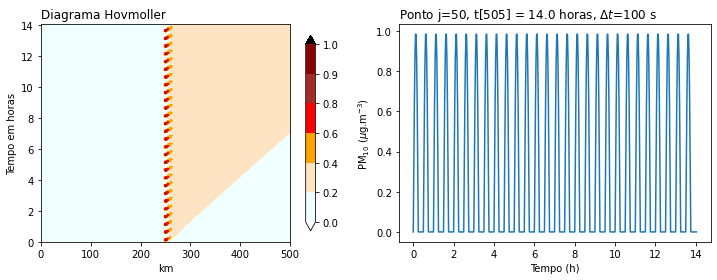

In [2]:
# Condições do exercício
# ----------------------
C = np.zeros((Nx, Nt))

for n in range(1, Nt):
    C[50,n-1] = fonte(wave(t,n-1))
    C = euler_back(C, n, CFL)

# Figura
hovm(X, T, C, ylabel, "ordem1", n, dt, t)
    

# Leapfrog 2a ordem

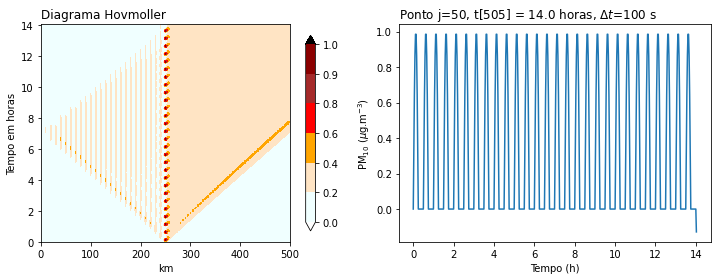

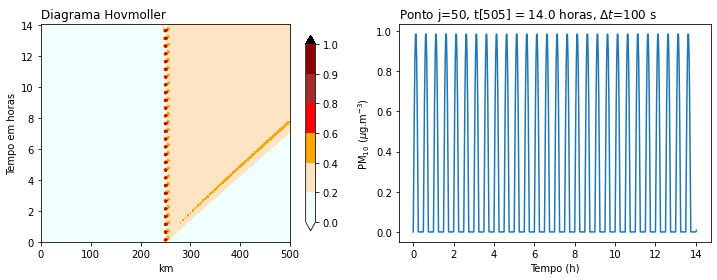

In [3]:
# Condições do exercício
# ----------------------
C_l = np.zeros((Nx, Nt))
C_lf = C_l.copy()

for n in range(1, Nt):
    C_l[50,n-1] = fonte(wave(t,n-1))
    C_l = leap2(C_l, n, CFL)

    C_lf[50,n-1] = fonte(wave(t,n-1))
    C_lf = leap2(C_lf, n, CFL, f_space=True, f_time=True)
    

# Figura
hovm(X, T, C_l, ylabel, "leap2", n, dt, t)
hovm(X, T, C_lf, ylabel, "leap2_filt", n, dt, t)

# 4a ordem

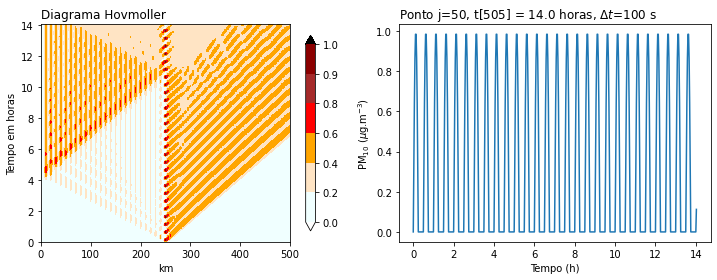

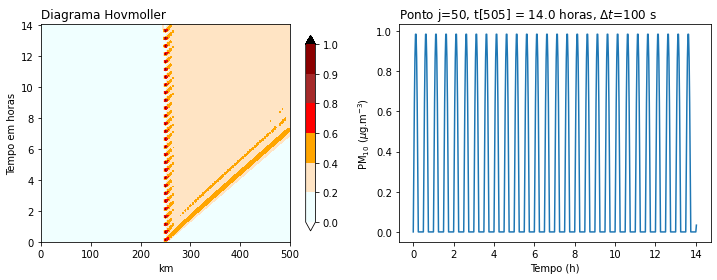

In [4]:
# Condições do exercício
# ----------------------
C_4o = np.zeros((Nx, Nt))
C_4of = C_4o.copy()

for n in range(1, Nt):
    # Não filtrado
    C_4o[50,n-1] = fonte(wave(t,n-1))
    C_4o = ordem4(C_4o,n, CFL)

    # Filtrado
    C_4of[50,n-1] = fonte(wave(t,n-1))
    C_4of = ordem4(C_4of,n, CFL, f_space=True, f_time = True,)
    
# Figura
hovm(X, T, C_4o, ylabel, "leap4", n, dt, t)
hovm(X, T, C_4of, ylabel, "leap4", n, dt, t)

# Implícito: Crank-Nicolson

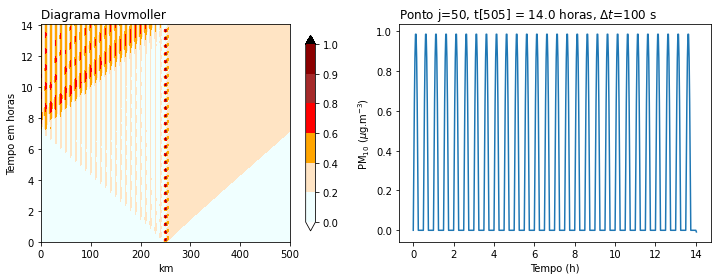

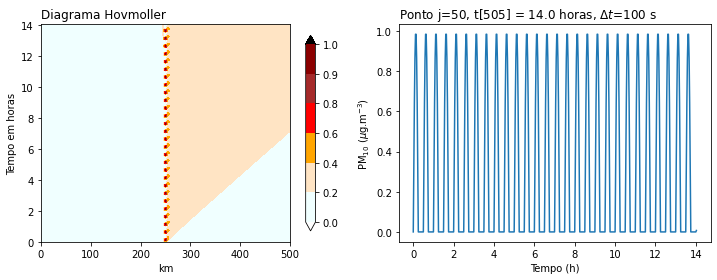

In [6]:
# Condições do exercício
# ----------------------
C_cr = np.zeros((Nx, Nt))
C_crf = C_cr.copy()
A, B = crank_matrix(CFL, x)

for n in range(1, Nt):
    C_cr[50,n-1] = fonte(wave(t,n-1))
    C_cr = crank(A, B, C_cr, n, CFL, f_space=False, f_time = False)

    C_crf[50,n-1] = fonte(wave(t,n-1))
    C_crf = crank(A, B, C_crf, n, CFL, f_space=True, f_time = True)
    
# Figura
hovm(X, T, C_cr, ylabel, "crank", n, dt, t)
hovm(X, T, C_crf, ylabel, "crank", n, dt, t)

In [9]:
filenames = []
# plot the line chart
for n in range(0,Nt-5,2):
    fig, ax = plt.subplots(figsize=[12,4])
    ax.plot(x/1000, C_s[:,n], color = 'k', linestyle = 'solid', label="Analítico")
    ax.plot(x/1000, C[:,n], color = 'r', linestyle = 'solid', label="1a ordem")
    #ax.plot(x/1000, C_l[:,n], color = 'g', linestyle = 'solid', label="Leapfrog 2")
    ax.plot(x/1000, C_lf[:,n], color = 'deeppink', linestyle = 'solid', label="Leapfrog 2-f")
    #ax.plot(x/1000, C_4o[:,n], color = 'm', linestyle = 'solid', label="4a ordem")
    ax.plot(x/1000, C_4of[:,n], color = 'b', linestyle = 'solid', label="4a ordem-f")
    #ax.plot(x/1000, C_cr[:,n], color = 'orange', linestyle = 'solid', label="CN")
    ax.plot(x/1000, C_crf[:,n], color = 'peru', linestyle = 'solid', label="CN-f")
    ax.set_ylim(-1,2)
    ax.set_title(f"tempo={round((n*dt/3600),1)} h, $\Delta t$={dt} s.")
    ax.legend()
    ax.set_ylabel(ylabel)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=300)
    plt.close() # build gif

with imageio.get_writer('gifs/test_filtrado.gif', mode='I', duration = .15) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  